In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scienceplots
import scipy.stats as st
plt.style.use(['science', 'grid'])
# plt.rcParams['text.latex.preamble'] = r'''
#     # \usepackage[T1]{fontenc}
#     # \usepackage{XCharter}
#     # \usepackage[charter,vvarbb,scaled=1.05]{newtxmath}
# '''

plt.rcParams['text.latex.preamble'] = r'''
        \usepackage[T1]{fontenc}
        \usepackage{newtxtext,newtxmath}
    '''

import os
import sys
import re
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from dynamic_tasker.access import *
from dynamic_tasker.orbits import *
from dynamic_tasker.constants import *
from dynamic_tasker.cameras import *
from dynamic_tasker.schedulers import *
from dynamic_tasker.rotations import *
from tqdm import tqdm

%load_ext autoreload
%autoreload 2


In [ ]:
# Generate a schedule...
h = 400
os.chdir("./exploration")
requests = load_worldcities(10000)
t0 = datetime.datetime(2024, 1, 1, 12, 0, 0)
orbit = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(51.6), Omega=np.pi - 0.05, M=np.pi/2, t=t0)
t_end = datetime.datetime(2024, 1, 1, 12, 17, 0)
accesses = get_accesses(requests, orbit, 500, 30, t0, t_end)
width=800
height=600
t_s = 10
t_dotsq = 4
def agility_bangbang(theta):
    return t_s + t_dotsq * np.sqrt(np.abs(theta))



3.0915926535897933


In [3]:
schedule = milp_schedule(accesses, requests, agility_bangbang)
# Calculate tasks/sec
tasks_per_sec = len(schedule) / (t_end - t0).total_seconds()
prob_task_good = 0.34

$$d = R \arccos\!\left(\frac{(R+h)\sin^2\theta + \cos\theta\,\sqrt{R^2 - (R+h)^2 \sin^2\theta}}{R}\right)$$


In [4]:
def ecef2pitchroll(pos_ecef, v_ecef, average_vec):
    # Unproject test    
    Up = pos_ecef / np.linalg.norm(pos_ecef)

    Along = v_ecef / np.linalg.norm(v_ecef)
    Right = np.cross(Along, Up)
    Right = Right / np.linalg.norm(Right)

    Along = np.cross(Up, Right)
    Along = Along / np.linalg.norm(Along)

    R_ecef_to_body = np.vstack([Right, Along, Up])

    v_local = R_ecef_to_body @ average_vec
    v_local_norm = v_local / np.linalg.norm(v_local)  # normalize for angle calculations

    pitch = -np.arctan2(v_local_norm[1], v_local_norm[2])
    roll  = -np.arctan2(v_local_norm[0], v_local_norm[2])

    pitch_deg = np.degrees(pitch) * 1
    roll_deg  = np.degrees(roll)

    return pitch_deg, roll_deg

def project_in_box(pitch_deg, roll_deg, orbit, K, t, accesses, points):
    # First, project and see if it's in the box
    points_eci = np.array([ecef2eci(p, t) for p in points])
    ecef_projected_dir = project_from_orbit(points_eci, K, orbit, t, pitch_angle=pitch_deg, roll_angle=roll_deg)
    # Figure out how many are in the box
    in_box_idx = np.array([i for i, p in enumerate(ecef_projected_dir) if p[0] >= 0 and p[0] <= width and p[1] >= 0 and p[1] <= height])
    return [a for i, a in enumerate(accesses) if i in in_box_idx], in_box_idx

def filter_accesses_horizon(orbit, time, accesses):
    return [(r, a, t, access, idx) for r, a, t, access, idx in accesses if t >= time and t <= time + datetime.timedelta(hours=1) and dist(pos_ecef, r) < horizon_distance(orbit) and a <= 30]

# def evaluate_lookahead_all(time, orbit, accesses_current):
#     accesses_filtered = filter_accesses_horizon(orbit, time, accesses_current)
#     # Let's try evaluating on a real dataset...
#     points = np.array([r for r, _, _, _, _ in accesses_filtered])
#     idxs = np.array([i for _, _, _, _, i in accesses_filtered])
    
#     # Take the average
#     average_vec = pos_ecef - (np.mean(points, axis=0))

#     # Get the angle between that and nadir
#     nadir = -pos_ecef/np.linalg.norm(pos_ecef)
#     lookahead_angle = np.arccos(np.dot(-nadir, average_vec)/np.linalg.norm(average_vec))
#     pitch_deg, roll_deg = ecef2pitchroll(pos_ecef, v_ecef, average_vec)

#     projected_accesses, in_box_idx = project_in_box(pitch_deg, roll_deg, orbit, t, accesses_filtered, points)
#     not_observed = np.array([not accesses_filtered[i][-1].state["observed"] for i in in_box_idx]).astype(int)

#     total_unobserved_inbox = np.sum(not_observed)
#     reward = total_unobserved_inbox * 1
#     action=(pitch_deg, roll_deg)

#     return action, reward

def analytic_chain_probability(L, lam, M, c):
    if L < (M-1)*c:
        return 0.0
    x = L - (M-1)*c
    # Note: scipy's gamma.cdf(x, a, scale) uses 'a' as the shape and scale=1/rate.
    return st.gamma.cdf(x, a=M-1, scale=1/lam)

def expected_advantage(N, t_total, t_gap, A_min, A_max):
   all_adv = np.arange(A_min, A_max+1)

   probabilities = np.array([analytic_chain_probability(t_total, N/t_total * 1/3, adv + 2, t_gap) for adv in all_adv])
   probabilities = [probabilities[i] - probabilities[i+1] for i in range(len(probabilities)-1)]
   probabilities = np.append(probabilities, probabilities[-1])
   
   return np.sum(probabilities * all_adv)

def actual_advantage(pitch_deg, roll_deg, orbit, K, time, accesses_filtered, points, schedule):
    accesses_inbox, in_box_idx = project_in_box(pitch_deg, roll_deg, orbit, K, time, accesses_filtered, points)
    N = len([a for a in accesses_inbox if a[3].state["observed"] == False]) * 0.34
    adv = 0
    if(N > 0):
        t_total = np.max([a[2] for a in accesses_inbox]) - np.min([a[2] for a in accesses_inbox])
        t_gap = agility_bangbang(30)

        if(t_total.total_seconds() > 0):
            adv = expected_advantage(N, t_total.total_seconds(), t_gap, 2, 40)

    # Now calculate cost...
    # Check how many tasks in the schedul we miss
    schedule_filtered = [s for s in schedule if s.time > time and s.time <= time + datetime.timedelta(hours=1)]
    # Total lookahead maneuver time
    # No setting time for lookahead
    # Assume 20 deg boresight angle
    t_maneuver = 2 * (agility_bangbang(pitch_deg - 35)) - agility_bangbang(0)

    schedule_missed = [s for s in schedule_filtered if time + datetime.timedelta(seconds=t_maneuver) > s.time]

    cost = len(schedule_missed) * 0.34
    utility = adv - cost
    missed = len(schedule_missed)
    return accesses_inbox, in_box_idx, utility, adv, cost, missed, t_maneuver

def evaluate_lookahead_chain(time, orbit, accesses_current, K):
    accesses_filtered = filter_accesses_horizon(orbit, time, accesses_current)
    # Let's do a test to figure out what the heuristic will do best at...
    points = np.array([r for r, _, _, _, _ in accesses_filtered])
    idxs = np.array([i for _, _, _, _, i in accesses_filtered])

    roll_deg = 0
    pitch_degs = np.linspace(0, 70)

    expected_utilities = []
    expected_advantages = []
    expected_costs = []
    for pitch_deg in pitch_degs:
        _, _, utility, adv, cost, _, _ = actual_advantage(pitch_deg, roll_deg, orbit, K, time, accesses_filtered, points, schedule)
        
        expected_utilities.append(utility)
        expected_advantages.append(adv)
        expected_costs.append(cost)

    # Find the maximum advantage
    max_adv = np.max(expected_utilities)
    max_idx = np.argmax(expected_utilities)
    # Find the pitch angle that gives the maximum advantage
    best_pitch_deg = pitch_degs[max_idx]

    # Recalculate in box
    accesses_inbox, in_box_idx, utility, adv, cost, missed, t_maneuver = actual_advantage(best_pitch_deg, roll_deg, orbit, K, time, accesses_filtered, points, schedule)

    mapped_in_box_idx = [idxs[i] for i in in_box_idx]
    # Recalculate utility

    return ((best_pitch_deg, roll_deg), mapped_in_box_idx, expected_utilities, expected_advantages, expected_costs, utility, adv, cost, missed, t_maneuver)

def roll2crosstrack(angle, h):
    R = Constants.R_E
    theta = np.radians(angle)
    return np.sign(theta) *  R * np.arccos(((R + h) * (np.sin(theta)) ** 2 + np.cos(theta) * np.sqrt(R**2 - ((R + h)**2) * (np.sin(theta) ** 2)))/(R))

def subtending_angle_from_fov(fov, h):
    sign = np.sign(fov)
    angle = np.abs(fov)
    beta = np.pi - np.arcsin((Constants.R_E + h)/(Constants.R_E) * np.sin(angle)) # obtuse angle
    
    theta = np.pi - (angle + beta)
    return theta * sign

def accesses2track(accesses, orbit, t0, t_end):
    v_orbit = v_orb(orbit.a - Constants.R_E)
    # Along, across...
    track = [(a.time - t0).total_seconds() * v_orbit for a in accesses]
    roll2cr = [roll2crosstrack(a.angle, orbit.a - Constants.R_E) for a in accesses]
    
    return track, roll2cr

for a in accesses:
    a.state = {"observed": False}



  0%|          | 0/100 [00:00<?, ?it/s]

42 17


  1%|          | 1/100 [00:06<10:31,  6.38s/it]

42 17


  2%|▏         | 2/100 [00:13<10:39,  6.53s/it]

42 13


  3%|▎         | 3/100 [00:19<10:24,  6.44s/it]

42 17


  4%|▍         | 4/100 [00:35<16:25, 10.27s/it]

42 8


  5%|▌         | 5/100 [00:41<14:03,  8.88s/it]

42 15


  6%|▌         | 6/100 [00:48<12:42,  8.11s/it]

42 18


  7%|▋         | 7/100 [00:57<13:15,  8.56s/it]

42 14


  8%|▊         | 8/100 [01:04<12:07,  7.90s/it]

42 13


  9%|▉         | 9/100 [01:10<11:11,  7.38s/it]

42 21


 10%|█         | 10/100 [01:17<10:49,  7.21s/it]

42 11


 11%|█         | 11/100 [01:24<10:31,  7.09s/it]

42 13


 12%|█▏        | 12/100 [01:30<10:10,  6.94s/it]

42 15


 13%|█▎        | 13/100 [01:37<10:05,  6.96s/it]

42 19


 14%|█▍        | 14/100 [01:44<09:55,  6.93s/it]

42 11


 15%|█▌        | 15/100 [01:51<09:40,  6.83s/it]

42 17


 16%|█▌        | 16/100 [01:58<09:36,  6.86s/it]

42 14


 17%|█▋        | 17/100 [02:14<13:30,  9.76s/it]

42 15


 18%|█▊        | 18/100 [02:23<12:52,  9.42s/it]

42 13


 19%|█▉        | 19/100 [02:31<12:06,  8.97s/it]

42 11


 20%|██        | 20/100 [02:39<11:45,  8.81s/it]

42 13


 21%|██        | 21/100 [02:47<11:19,  8.60s/it]

42 14


 22%|██▏       | 22/100 [02:56<11:14,  8.65s/it]

42 8


 23%|██▎       | 23/100 [03:06<11:39,  9.08s/it]

42 11


 24%|██▍       | 24/100 [03:15<11:29,  9.07s/it]

42 17


 25%|██▌       | 25/100 [03:25<11:34,  9.26s/it]

42 14


 26%|██▌       | 26/100 [03:47<16:11, 13.13s/it]

42 14


 27%|██▋       | 27/100 [03:55<14:11, 11.67s/it]

42 11


 28%|██▊       | 28/100 [04:04<12:54, 10.76s/it]

42 11


 29%|██▉       | 29/100 [04:12<11:46,  9.95s/it]

42 10


 30%|███       | 30/100 [04:21<11:17,  9.67s/it]

42 12


 31%|███       | 31/100 [04:36<12:47, 11.12s/it]

42 11


 32%|███▏      | 32/100 [04:55<15:19, 13.52s/it]

42 15


 33%|███▎      | 33/100 [05:12<16:15, 14.56s/it]

42 18


 34%|███▍      | 34/100 [05:28<16:35, 15.08s/it]

42 18


 35%|███▌      | 35/100 [06:09<24:37, 22.72s/it]

42 11


 36%|███▌      | 36/100 [06:26<22:32, 21.14s/it]

42 19


 37%|███▋      | 37/100 [06:54<24:15, 23.11s/it]

42 15


 38%|███▊      | 38/100 [07:11<21:59, 21.28s/it]

42 19


 39%|███▉      | 39/100 [07:59<29:45, 29.26s/it]

42 19


 40%|████      | 40/100 [08:16<25:39, 25.66s/it]

42 10


 41%|████      | 41/100 [08:32<22:16, 22.65s/it]

42 15


 42%|████▏     | 42/100 [08:50<20:36, 21.32s/it]

42 16


 43%|████▎     | 43/100 [09:05<18:36, 19.58s/it]

42 15


 44%|████▍     | 44/100 [09:21<17:05, 18.31s/it]

42 14


 45%|████▌     | 45/100 [09:37<16:07, 17.59s/it]

42 16


 46%|████▌     | 46/100 [09:53<15:34, 17.31s/it]

42 23


 47%|████▋     | 47/100 [10:10<15:09, 17.15s/it]

42 16


 48%|████▊     | 48/100 [10:26<14:33, 16.80s/it]

42 16


 49%|████▉     | 49/100 [11:00<18:46, 22.08s/it]

42 11


 50%|█████     | 50/100 [11:39<22:26, 26.93s/it]

42 17


 51%|█████     | 51/100 [12:09<22:55, 28.08s/it]

42 12


 52%|█████▏    | 52/100 [12:26<19:41, 24.62s/it]

42 14


 53%|█████▎    | 53/100 [12:42<17:17, 22.06s/it]

42 12


 54%|█████▍    | 54/100 [12:59<15:40, 20.45s/it]

42 15


 55%|█████▌    | 55/100 [13:09<13:07, 17.50s/it]

42 15


 56%|█████▌    | 56/100 [13:19<10:59, 14.98s/it]

42 19


 57%|█████▋    | 57/100 [13:27<09:18, 12.98s/it]

42 11


 58%|█████▊    | 58/100 [13:35<08:07, 11.60s/it]

42 15


 59%|█████▉    | 59/100 [13:43<07:14, 10.60s/it]

42 19


 60%|██████    | 60/100 [13:53<06:50, 10.27s/it]

42 14


 61%|██████    | 61/100 [14:02<06:20,  9.76s/it]

42 20


 62%|██████▏   | 62/100 [14:10<06:00,  9.48s/it]

42 18


 63%|██████▎   | 63/100 [14:19<05:37,  9.12s/it]

42 18


 64%|██████▍   | 64/100 [14:26<05:14,  8.73s/it]

42 16


 65%|██████▌   | 65/100 [14:35<05:03,  8.68s/it]

42 13


 66%|██████▌   | 66/100 [14:48<05:37,  9.92s/it]

42 16


 67%|██████▋   | 67/100 [15:05<06:40, 12.14s/it]

42 16


 68%|██████▊   | 68/100 [15:16<06:13, 11.68s/it]

42 13


 69%|██████▉   | 69/100 [15:24<05:34, 10.78s/it]

42 16


 70%|███████   | 70/100 [15:33<05:04, 10.14s/it]

42 17


 71%|███████   | 71/100 [15:41<04:34,  9.45s/it]

42 9


 72%|███████▏  | 72/100 [15:49<04:12,  9.03s/it]

42 10


 73%|███████▎  | 73/100 [15:57<03:55,  8.73s/it]

42 12


 74%|███████▍  | 74/100 [16:06<03:47,  8.75s/it]

42 12


 75%|███████▌  | 75/100 [16:14<03:33,  8.56s/it]

42 16


 76%|███████▌  | 76/100 [16:23<03:28,  8.68s/it]

42 10


 77%|███████▋  | 77/100 [16:31<03:14,  8.45s/it]

42 11


 78%|███████▊  | 78/100 [16:39<03:07,  8.50s/it]

42 13


 79%|███████▉  | 79/100 [16:54<03:38, 10.39s/it]

42 20


 80%|████████  | 80/100 [17:04<03:23, 10.17s/it]

42 15


 81%|████████  | 81/100 [17:31<04:48, 15.17s/it]

42 9


 82%|████████▏ | 82/100 [17:40<04:00, 13.36s/it]

42 16


 83%|████████▎ | 83/100 [17:48<03:18, 11.70s/it]

42 14


 84%|████████▍ | 84/100 [17:56<02:51, 10.74s/it]

42 14


 85%|████████▌ | 85/100 [18:05<02:31, 10.07s/it]

42 17


 86%|████████▌ | 86/100 [18:13<02:14,  9.57s/it]

42 9


 87%|████████▋ | 87/100 [18:21<01:59,  9.22s/it]

42 18


 88%|████████▊ | 88/100 [18:30<01:47,  8.92s/it]

42 17


 89%|████████▉ | 89/100 [18:38<01:36,  8.80s/it]

42 11


 90%|█████████ | 90/100 [18:47<01:26,  8.67s/it]

42 16


 91%|█████████ | 91/100 [18:55<01:16,  8.53s/it]

42 8


 92%|█████████▏| 92/100 [19:04<01:09,  8.70s/it]

42 10


 93%|█████████▎| 93/100 [19:12<00:58,  8.42s/it]

42 13


 94%|█████████▍| 94/100 [19:20<00:49,  8.33s/it]

42 14


 95%|█████████▌| 95/100 [19:28<00:41,  8.22s/it]

42 14


 96%|█████████▌| 96/100 [19:36<00:32,  8.20s/it]

42 15


 97%|█████████▋| 97/100 [19:44<00:24,  8.18s/it]

42 11


 98%|█████████▊| 98/100 [19:52<00:16,  8.20s/it]

42 14


 99%|█████████▉| 99/100 [20:01<00:08,  8.27s/it]

42 12


100%|██████████| 100/100 [20:09<00:00, 12.10s/it]


17 17


ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._axes.Axes'>

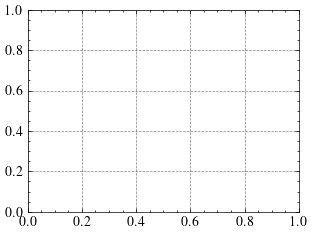

In [5]:
N = 1

omni_schedule_perf = []
initial_schedule_perf = []
dt_schedule_perf = []

for i in tqdm(range(N)):
    for a in accesses:
        a.state = {"observed": False, "cloudy": np.random.rand() < 0.66}

    schedule = milp_schedule(accesses, requests, agility_bangbang)
    schedule_omni = milp_schedule([a for a in accesses if not a.state["cloudy"]], requests, agility_bangbang)

    print(len(schedule), len([s for s in schedule if not s.state["cloudy"]]))
    initial_schedule_perf.append((len(schedule), len([s for s in schedule if not s.state["cloudy"]])))
    omni_schedule_perf.append((len(schedule_omni), len([s for s in schedule_omni if not s.state["cloudy"]])))

    K = get_intrinsics(800, width//2, height//2)

    # fig = plt.figure(figsize=(10, 10))
    # Create a cartopy GeoAxes with PlateCarree projection
    # ax = plt.axes(projection=ccrs.PlateCarree())
    lookahead_plotted=False
    # box = np.array([[0, 0], [width, 0], [width, height], [0, height], [0, 0]])

    def create_high_res_box(width, height, points_per_edge=10):
        # Create the base box corners
        corners = np.array([[0, 0], [width, 0], [width, height], [0, height]])
        
        # Create high resolution edges
        edges = []
        for i in range(4):
            start = corners[i]
            end = corners[(i + 1) % 4]
            # Generate evenly spaced points along each edge
            edge_points = np.linspace(start, end, points_per_edge)
            edges.append(edge_points[:-1])  # Exclude last point to avoid duplicates
        
        # Combine all edges and add the closing point
        high_res_box = np.vstack(edges + [corners[0]])
        return high_res_box

    # Create high resolution box with 20 points per edge
    box_hires = create_high_res_box(width, height, points_per_edge=12)


    utilities, advs, costs = [], [], []
    i = 0
    while(i < len(schedule)):
        s = schedule[i]
        t = s.time
        # Convert all accesses to ECEF
        accesses_converted = [(latlong2ecef([a.lat, a.long]), a.angle, a.time, a, i) for i, a in enumerate(accesses)]
        # Get current orbit position in ECEF
        orbit_new = propagate_orbit(orbit, t)
        r , v = kepler2eci(orbit_new)
        pos_ecef = eci2ecef(r, t)
        v_ecef = eci2ecef(v, t)
        
        lookahead_action, in_box_idx, all_utilities, all_advs, all_costs, utility, adv, cost, missed, maneuver_time = evaluate_lookahead_chain(t, orbit_new, accesses_converted, K)
        lookahead_reward = utility
        utilities.append(all_utilities)
        advs.append(all_advs)
        costs.append(all_costs)

        pitch_deg, roll_deg = lookahead_action

        # For plotting
        ecef_unprojected_dir = -(r - unproject_from_orbit(box_hires, 1, K, orbit_new, t, pitch_angle=pitch_deg, roll_angle=roll_deg))
        # Calculate Earth line intersections in ECI
        
        eci_intersections = [earth_line_intersection(r, d, horizon_snap=True)[0] for d in ecef_unprojected_dir]
        # Convert to latlong
        latlong_intersections = [ecef2latlong(eci2ecef(i, t)) for i in eci_intersections]
        if(lookahead_reward > 0):
            # Mark the accesses as observed
            for j in in_box_idx:
                accesses[accesses_converted[j][-1]].state["observed"] = True
            
            # Plot the lookahead
            # plt.plot([a[1] for a in latlong_intersections], [a[0] for a in latlong_intersections], 'r', transform=ccrs.PlateCarree(), label='Lookahead' if not lookahead_plotted else None)
            lookahead_plotted = True

            # TODO: Re-optimize the schedule...
            min_time = t
            max_time = np.max([a[2] for a in accesses_converted if a[-2].state["observed"]])

            schedule_slice_idxs = [i for i, s in enumerate(schedule) if s.time >= min_time and s.time <= max_time]
            schedule_slice = schedule[min(schedule_slice_idxs):max(schedule_slice_idxs)]
            max_schedule_slice_idx = max(schedule_slice_idxs)

            # TODO: Add the missed-schedule maneuver time to the min time
            accesses_in_time = [a for a in accesses if a.time >= min_time + datetime.timedelta(seconds=maneuver_time) and a.time <= max_time and not (a.state["observed"] and a.state["cloudy"])] 
            # Make sure to add the bounding accesses
            if(schedule[i] not in accesses_in_time):
                accesses_in_time.insert(0, schedule[i])

            max_bounding = [(i, s) for i, s in enumerate(schedule) if s.time >= max_time][0]
            max_bounding_schedule_idx, max_bounding_schedule = max_bounding[0], max_bounding[1]
            if(max_bounding_schedule not in accesses_in_time):
                accesses_in_time.append(max_bounding_schedule)

            # Re-optimize the schedule, force in the bounding accesses
            # print([schedule[i], max_bounding_schedule])
            try:
                schedule_slice_optimized = milp_schedule(accesses_in_time, requests, agility_bangbang, [schedule[i], max_bounding_schedule])
            except Exception as e:
                print(e, [schedule[i], max_bounding_schedule], len(accesses_in_time))
            
            # Update the schedule
            schedule = schedule[:i] + schedule_slice_optimized[1:-1] + schedule[max_bounding_schedule_idx:]
        i += 1

    dt_schedule_perf.append((len(schedule), len([s for s in schedule if not s.state["cloudy"]])))

print(len(schedule), len([s for s in schedule if not s.state["cloudy"]]))

# Plot accesses
plt.plot([a.long for a in accesses if a.state["observed"]], [a.lat for a in accesses if a.state["observed"]], 'b.', transform=ccrs.PlateCarree(), label='Observed Accesses', markersize=5)
plt.plot([a.long for a in accesses if not a.state["observed"]], [a.lat for a in accesses if not a.state["observed"]], 'm.', transform=ccrs.PlateCarree(), label='Unobserved Accesses', markersize=5)
plt.plot([r.long for r in requests if r not in [x.request for x in accesses]], [r.lat for r in requests if r not in [x.request for x in accesses]], '.', transform=ccrs.PlateCarree(), label="All Requests", color='grey', markersize=3)
# May as well plot the orbit track
orbit_latlong = [kepler2latlong(propagate_orbit(orbit, t), orbit.t + datetime.timedelta(seconds=t)) for t in np.linspace(0, (t_end - t0).total_seconds(), 100)]
plt.plot([long for lat, long in orbit_latlong], [lat for lat, long in orbit_latlong], 'k-', label='Orbit Track')

# Show the start and end latlong
orbit_latlong_start = kepler2latlong(propagate_orbit(orbit, 0), t0)
orbit_latlong_end = kepler2latlong(propagate_orbit(orbit, (t_end - t0).total_seconds()), t_end)
print(orbit_latlong_start)
print(orbit_latlong_end)
plt.plot([orbit_latlong_start[1]], [orbit_latlong_start[0]], 'g*', transform=ccrs.PlateCarree(), label='Start', markersize=10)
plt.plot([orbit_latlong_end[1]], [orbit_latlong_end[0]], 'r*', transform=ccrs.PlateCarree(), label='End', markersize=10)

# Add coastlines
ax.stock_img()
ax.coastlines()
ax.set_extent([-15, 65, 15, 60], crs=ccrs.PlateCarree())
ax.legend(frameon=True, ncol=2)

# Add gridlines for latitude and longitude
gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gridlines.top_labels = False    # Disable labels at the top
gridlines.right_labels = False  # Disable labels on the right
plt.savefig('lookahead_chain.png', dpi=300)
plt.show()

In [6]:
# Check for duplicates in schedule
# for i, s in enumerate(schedule):
#     print(s.requestid)

# Check that they all follow agi\lity constraints
for i in range(len(schedule) - 1):
    # print((schedule[i+1].time - schedule[i].time).total_seconds(), agility_bangbang(schedule[i].angle - schedule[i+1].angle))
    if((schedule[i+1].time - schedule[i].time).total_seconds() < agility_bangbang(schedule[i].angle - schedule[i+1].angle)):
        print(f"Warning: Schedule does not follow agility constraints at {schedule[i].name} and {schedule[i+1].name}")


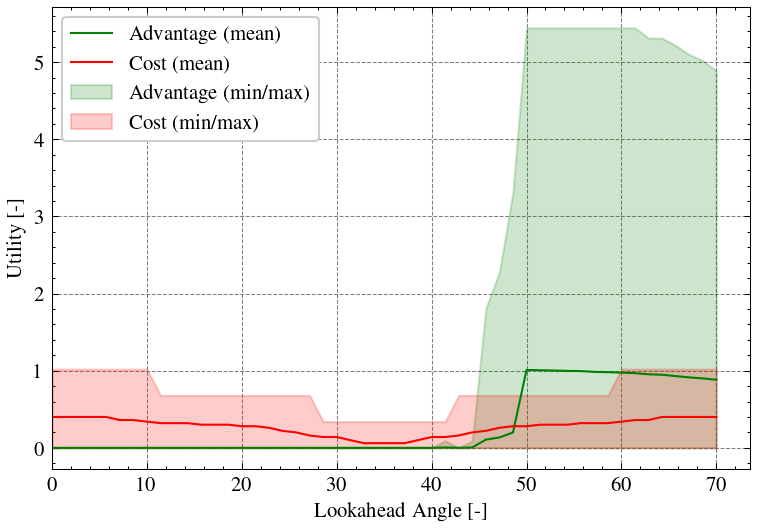

In [7]:
# Plot some costs, utilities
fig = plt.figure(figsize=(6, 4), dpi=150)

angles = np.linspace(0, 70)

# plt.plot(np.mean(utilities, axis=0), label='Utility', color='blue')
plt.plot(angles, np.mean(advs, axis=0), label='Advantage (mean)', color='green')
plt.plot(angles, np.mean(costs, axis=0), label='Cost (mean)', color='red')
plt.plot([])

# Plot the min and max of each
# plt.fill_between(range(len(utilities[0])), np.min(utilities, axis=0), np.max(utilities, axis=0), color='blue', alpha=0.2)
plt.fill_between(angles, np.min(advs, axis=0), np.max(advs, axis=0), color='green', alpha=0.2, label='Advantage (min/max)')
plt.fill_between(angles, np.min(costs, axis=0), np.max(costs, axis=0), color='red', alpha=0.2 , label='Cost (min/max)')

plt.legend()
plt.xlim(0)

plt.xlabel('Lookahead Angle [-]')
plt.ylabel('Utility [-]')
plt.show()


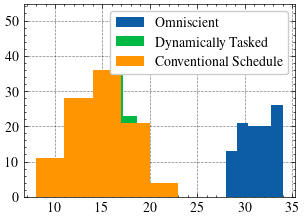

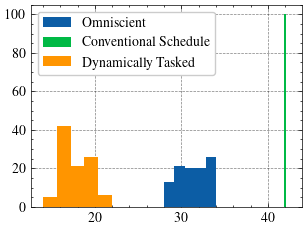

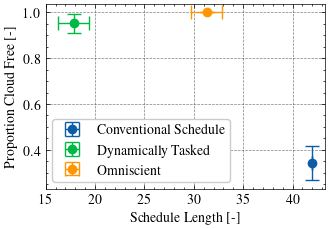

In [8]:
# Make a histogram plot
plt.figure(figsize=(3.5, 2.5))
n_bins = 5
plt.hist([x[1] for x in omni_schedule_perf], label='Omniscient', bins=n_bins)
plt.hist([x[1] for x in dt_schedule_perf], label='Dynamically Tasked', bins=n_bins)
plt.hist([x[1] for x in initial_schedule_perf], label='Conventional Schedule', bins=n_bins)
plt.legend()
plt.show()

# Now for schedule length
plt.hist([x[0] for x in omni_schedule_perf], label='Omniscient', bins=n_bins)
plt.hist([x[0] for x in initial_schedule_perf], label='Conventional Schedule', bins=n_bins)
plt.hist([x[0] for x in dt_schedule_perf], label='Dynamically Tasked', bins=n_bins)
plt.legend()
plt.show()

# Now figure out the error bars

# Calculate proportion cloud free
cloud_free_omni = [x[1]/x[0] for x in omni_schedule_perf]
cloud_free_initial = [x[1]/x[0] for x in initial_schedule_perf]
cloud_free_dt = [x[1]/x[0] for x in dt_schedule_perf]

# Error bars
cloud_free_omni_err = np.std(cloud_free_omni)
cloud_free_initial_err = np.std(cloud_free_initial)
cloud_free_dt_err = np.std(cloud_free_dt)

# Cloud free centroids
cloud_free_omni_centroid = np.mean(cloud_free_omni)
cloud_free_initial_centroid = np.mean(cloud_free_initial)
cloud_free_dt_centroid = np.mean(cloud_free_dt)


# Schedule length error bars
schedule_length_omni_err = np.std([x[0] for x in omni_schedule_perf])
schedule_length_initial_err = np.std([x[0] for x in initial_schedule_perf])
schedule_length_dt_err = np.std([x[0] for x in dt_schedule_perf])

# Schedule length centroids
schedule_length_omni_centroid = np.mean([x[0] for x in omni_schedule_perf])
schedule_length_initial_centroid = np.mean([x[0] for x in initial_schedule_perf])
schedule_length_dt_centroid = np.mean([x[0] for x in dt_schedule_perf])

# Plot the centroids and error bars for all
plt.figure(figsize=(3.5, 2.5))
plt.errorbar(schedule_length_initial_centroid, cloud_free_initial_centroid,
             xerr=schedule_length_initial_err, yerr=cloud_free_initial_err,
             fmt='o', label='Conventional Schedule', capsize=5)
plt.errorbar(schedule_length_dt_centroid, cloud_free_dt_centroid,
             xerr=schedule_length_dt_err, yerr=cloud_free_dt_err,
             fmt='o', label='Dynamically Tasked', capsize=5)
plt.errorbar(schedule_length_omni_centroid, cloud_free_omni_centroid,
             xerr=schedule_length_omni_err, yerr=cloud_free_omni_err,
             fmt='o', label='Omniscient', capsize=5)

plt.xlabel('Schedule Length [-]')
plt.ylabel('Proportion Cloud Free [-]')
plt.legend()
plt.tight_layout()
plt.savefig("smallsat_schedule_perf.pdf")
plt.show()



In [2]:
# Comparisons

# Compare how much better the DT is than the conventional schedule
improved = [x[1]/y[1] for x, y in zip(dt_schedule_perf, initial_schedule_perf)]
print(np.mean(improved))
print(np.max(improved))
print(np.min(improved))

improved_bool = [x[1] > y[1] for x, y in zip(dt_schedule_perf, initial_schedule_perf)]
print(improved_bool)
print(np.mean(improved_bool))

# Compare how much shorter the DT is than the omniscient
shorter = [x[0]/y[0] for x, y in zip(dt_schedule_perf, omni_schedule_perf)]

print(np.mean(shorter))




NameError: name 'dt_schedule_perf' is not defined